In [30]:
import numpy as np
import pandas as pd
from statsmodels.nonparametric.smoothers_lowess import lowess
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as sm

import nltk
nltk.download('omw-1.4')

from sklearn import linear_model as lm
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, classification_report, accuracy_score
from sklearn.feature_extraction.text import CountVectorizer

import re
from string import punctuation
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
import gensim
import string
from gensim.models import Doc2Vec  
import html
from bs4 import BeautifulSoup
from collections import Counter


# Plot settings
plt.rcParams['figure.figsize'] = (12, 9)
plt.rcParams['font.size'] = 12

[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\ariesenihw\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ariesenihw\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ariesenihw\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Alright let's review the scraped data.

In [31]:
data = pd.read_csv("pubmed_data_full.csv")
data

,PubMedID,Title,URL,Abstract
0,37899090,Therapy with direct oral anticoagulants for se...,https://pubmed.ncbi.nlm.nih.gov/37899090,Antiphospholipid syndrome (APS) is a systemic ...
1,37878348,Treatment Outcomes With Licensed and Unlicense...,https://pubmed.ncbi.nlm.nih.gov/37878348,Stimulants (methylphenidate and amphetamines) ...
2,37866803,"AdipoRon and ADP355, adiponectin receptor agon...",https://pubmed.ncbi.nlm.nih.gov/37866803,Adiponectin replacement therapy holds the pote...
3,37864589,Exploring the logic and conducting a comprehen...,https://pubmed.ncbi.nlm.nih.gov/37864589,The potential benefits of adiponectin replacem...
4,37846549,Evaluation of pentamidine tolerability and eff...,https://pubmed.ncbi.nlm.nih.gov/37846549,Intravenous pentamidine is used for prophylaxi...
...,...,...,...,...
5832,1964663,Therapeutic application of subcutaneous low-mo...,https://pubmed.ncbi.nlm.nih.gov/1964663,Fifty patients presenting with acute deep-vein...
5833,2563187,"Relative efficacy of, and some adverse reactio...",https://pubmed.ncbi.nlm.nih.gov/2563187,Although it is a common belief that all antihy...
5834,3124679,Advanced ovarian cancer: long-term results of ...,https://pubmed.ncbi.nlm.nih.gov/3124679,To determine the efficacy of a 6-month course ...
5835,3431880,The analgesic effect of amitriptyline on chron...,https://pubmed.ncbi.nlm.nih.gov/3431880,The efficacy of amitriptyline was evaluated in...


Let's check if we have Nan's

In [32]:
rows_with_nan = data[data['Abstract'].isna() | data['Title'].isna() | data['PubMedID'].isna() | data['URL'].isna()]
rows_with_nan 

,PubMedID,Title,URL,Abstract
567,34534516,Considerations in boosting COVID-19 vaccine im...,https://pubmed.ncbi.nlm.nih.gov/34534516,NaN
677,34135024,Advancing American Kidney Health and the Role ...,https://pubmed.ncbi.nlm.nih.gov/34135024,NaN
824,33615348,New trials in the scene of cardiovascular dise...,https://pubmed.ncbi.nlm.nih.gov/33615348,NaN
840,33580678,Heart failure or heart success?,https://pubmed.ncbi.nlm.nih.gov/33580678,NaN
879,33439963,SCORED and SOLOIST: the next scores for SGLT2 ...,https://pubmed.ncbi.nlm.nih.gov/33439963,NaN
...,...,...,...,...
5749,10393496,KIGS and KIMS as tools for evidence-based medi...,https://pubmed.ncbi.nlm.nih.gov/10393496,NaN
5757,10191453,Towards evidence based emergency medicine: bes...,https://pubmed.ncbi.nlm.nih.gov/10191453,NaN
5758,10191452,Towards evidence based emergency medicine: bes...,https://pubmed.ncbi.nlm.nih.gov/10191452,NaN
5774,9597395,Should we prescribe antioxidants to patients w...,https://pubmed.ncbi.nlm.nih.gov/9597395,NaN


Alright we see 256 entries have NaN for the abstract so let's drop these.

In [33]:
data.dropna(inplace=True)
data

,PubMedID,Title,URL,Abstract
0,37899090,Therapy with direct oral anticoagulants for se...,https://pubmed.ncbi.nlm.nih.gov/37899090,Antiphospholipid syndrome (APS) is a systemic ...
1,37878348,Treatment Outcomes With Licensed and Unlicense...,https://pubmed.ncbi.nlm.nih.gov/37878348,Stimulants (methylphenidate and amphetamines) ...
2,37866803,"AdipoRon and ADP355, adiponectin receptor agon...",https://pubmed.ncbi.nlm.nih.gov/37866803,Adiponectin replacement therapy holds the pote...
3,37864589,Exploring the logic and conducting a comprehen...,https://pubmed.ncbi.nlm.nih.gov/37864589,The potential benefits of adiponectin replacem...
4,37846549,Evaluation of pentamidine tolerability and eff...,https://pubmed.ncbi.nlm.nih.gov/37846549,Intravenous pentamidine is used for prophylaxi...
...,...,...,...,...
5832,1964663,Therapeutic application of subcutaneous low-mo...,https://pubmed.ncbi.nlm.nih.gov/1964663,Fifty patients presenting with acute deep-vein...
5833,2563187,"Relative efficacy of, and some adverse reactio...",https://pubmed.ncbi.nlm.nih.gov/2563187,Although it is a common belief that all antihy...
5834,3124679,Advanced ovarian cancer: long-term results of ...,https://pubmed.ncbi.nlm.nih.gov/3124679,To determine the efficacy of a 6-month course ...
5835,3431880,The analgesic effect of amitriptyline on chron...,https://pubmed.ncbi.nlm.nih.gov/3431880,The efficacy of amitriptyline was evaluated in...


Let's inspect the top 30 most common words in the abstracts.

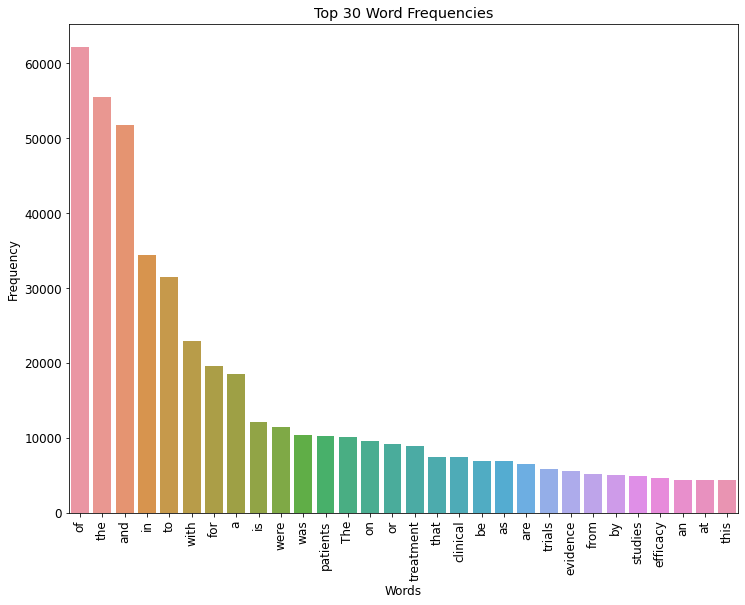

In [34]:
word_freq = {}
for sentence in data["Abstract"]:
    words = sentence.split()
    for word in words:
        if word not in word_freq:
            word_freq[word] = 1
        else: word_freq[word] += 1

df_word_freq = pd.DataFrame.from_dict(word_freq, orient='index', columns=['Frequency'])
df_word_freq = df_word_freq.sort_values(by='Frequency', ascending=False)

# Plot the word frequencies using seaborn
sns.barplot(x=df_word_freq.index[:30], y=df_word_freq['Frequency'][:30])
plt.xticks(rotation=90)
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Top 30 Word Frequencies')
plt.show()

So filtering out stopwords will be a vital step in cleaning the data for better documents embeddings.